In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import MaxNLocator

## Cargado de datos

In [12]:
task_ids = ['task_1816655']
todos_los_datos = []

for task_id in task_ids:
    for generacion in range(1, 31):
        ruta_archivo = f'resultados/{task_id}/resultados_generacion_{generacion}.csv'
        if os.path.exists(ruta_archivo):
            datos = pd.read_csv(ruta_archivo)
            datos['generacion'] = generacion
            todos_los_datos.append(datos)
        else:
            print(f'Archivo no encontrado: {ruta_archivo}')

# Unir todos los DataFrames en uno solo
df_total = pd.concat(todos_los_datos, ignore_index=True)

In [13]:
df_total

,D,A,B,x,y,beta_1,beta_2,beta_3,beta_4,beta_5,gamma_1,gamma_2,gamma_3,gamma_4,gamma_5,fitness,generacion
0,9.065351,0.000140,1.652183,437.0,561.0,0.717125,1.647549,0.914091,0.832711,0.318041,0.516057,0.412230,0.131683,0.445915,0.286237,0.754569,1
1,81.846016,0.000466,7.346697,371.0,565.0,0.100000,0.738844,0.143099,0.172419,0.922672,0.090000,0.180287,0.128789,0.155177,0.239299,0.828189,1
2,59.102909,0.000128,18.517599,419.0,526.0,1.343940,1.396184,0.236557,0.971037,1.536793,1.089676,0.327183,0.212901,0.282107,0.933428,0.670459,1
3,85.514755,0.000225,20.471083,404.0,566.0,1.638329,0.242402,1.716080,1.449326,0.790157,0.957640,0.218162,0.243090,0.791833,0.320786,0.781658,1
4,75.790405,0.000290,19.221537,381.0,554.0,0.100000,1.898761,1.853686,1.690428,0.551073,0.090000,0.637717,1.497621,0.234053,0.194706,0.837281,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.010000,0.000058,4.250800,405.0,555.0,1.578375,0.615462,1.748478,0.462404,0.785351,0.137518,0.254254,0.119206,0.416163,0.100000,0.439808,30
299996,24.638840,0.000100,8.800131,411.0,578.0,0.553341,0.100000,1.187835,0.793983,1.080675,0.154498,0.090000,0.112443,0.100000,0.139764,0.177732,30
299997,7.344729,0.000252,6.735447,461.0,560.0,0.918008,1.568777,0.100000,0.955825,1.098419,0.547905,0.090000,0.090000,0.185836,0.353150,0.851548,30
299998,11.203568,0.000001,5.471919,417.0,567.0,1.089486,0.134112,0.100000,1.939061,0.713730,0.346181,0.120700,0.090000,0.100000,0.707592,0.190321,30


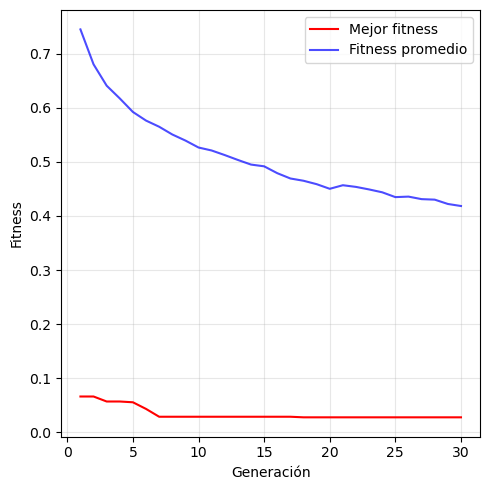

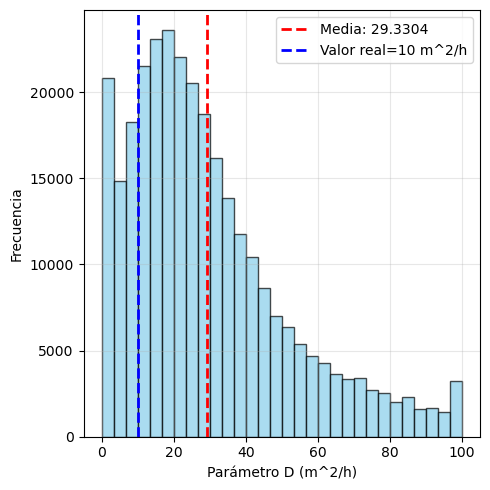

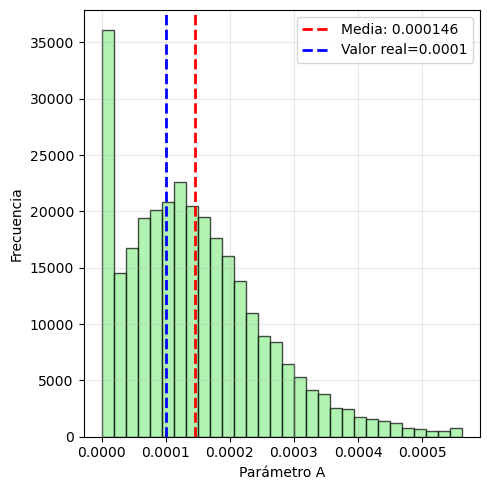

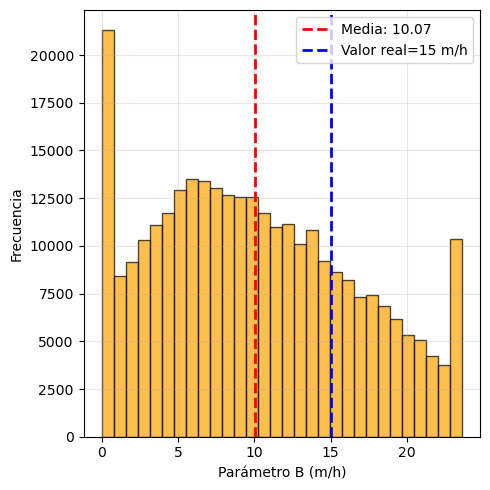

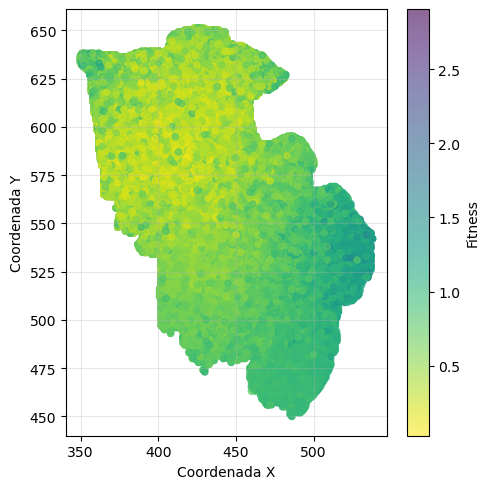

In [14]:
# Visualizaciones de los resultados del algoritmo genético

# 1. Evolución del fitness a lo largo de las generaciones
mejor_fitness = df_total.groupby('generacion')['fitness'].min()
fitness_promedio = df_total.groupby('generacion')['fitness'].mean()

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(mejor_fitness.index, mejor_fitness.values, '-', color='red', label='Mejor fitness')
ax.plot(fitness_promedio.index, fitness_promedio.values, '-', color='blue', alpha=0.7, label='Fitness promedio')
ax.set_xlabel('Generación')
ax.set_ylabel('Fitness')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('evolucion_fitness_hasta_gen_57.png', dpi=300, bbox_inches='tight')

# 2. Distribución del parámetro D
fig, ax = plt.subplots(figsize=(5, 5))
plt.hist(df_total['D'], bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(df_total['D'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df_total["D"].mean():.4f}')
plt.axvline(10, color='blue', linestyle='--', linewidth=2, label=f'Valor real={10} m^2/h')
ax.set_xlabel('Parámetro D (m^2/h)')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('distribucion_D_todas_las_generaciones.png', dpi=300, bbox_inches='tight')

# 3. Distribución del parámetro A
fig, ax = plt.subplots(figsize=(5, 5))
plt.hist(df_total['A'], bins=30, color='lightgreen', alpha=0.7, edgecolor='black')
plt.axvline(df_total['A'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df_total["A"].mean():.6f}')
plt.axvline(1e-4, color='blue', linestyle='--', linewidth=2, label=f'Valor real={1e-4}')
ax.set_xlabel('Parámetro A')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('distribucion_A_todas_las_generaciones.png', dpi=300, bbox_inches='tight')

# 4. Distribución del parámetro B
fig, ax = plt.subplots(figsize=(5, 5))
plt.hist(df_total['B'], bins=30, color='orange', alpha=0.7, edgecolor='black')
plt.axvline(df_total['B'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df_total["B"].mean():.2f}')
plt.axvline(15, color='blue', linestyle='--', linewidth=2, label=f'Valor real={15} m/h')
ax.set_xlabel('Parámetro B (m/h)')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('distribucion_B_todas_las_generaciones.png', dpi=300, bbox_inches='tight')

# 5. Distribución de puntos de ignición (x, y)
fig, ax = plt.subplots(figsize=(5, 5))
scatter = plt.scatter(df_total['x'], df_total['y'], 
                            c=df_total['fitness'], cmap='viridis_r', alpha=0.6, s=20)
ax.set_xlabel('Coordenada X')
ax.set_ylabel('Coordenada Y')
plt.colorbar(scatter, ax=ax, label='Fitness')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('distribucion_puntos_generacion_todas_las_generaciones.png', dpi=300, bbox_inches='tight')

# # 6. Correlación entre parámetros y fitness
# datos_numericos = df_total[['D', 'A', 'B', 'fitness']].corr()
# im = axes[1,2].imshow(datos_numericos, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
# axes[1,2].set_xticks(range(len(datos_numericos.columns)))
# axes[1,2].set_yticks(range(len(datos_numericos.columns)))
# axes[1,2].set_xticklabels(datos_numericos.columns)
# axes[1,2].set_yticklabels(datos_numericos.columns)
# axes[1,2].set_title('Matriz de Correlación')

# # Agregar valores de correlación
# for i in range(len(datos_numericos.columns)):
#     for j in range(len(datos_numericos.columns)):
#         text = axes[1,2].text(j, i, f'{datos_numericos.iloc[i, j]:.2f}',
#                             ha="center", va="center", color="black", fontweight='bold')

# plt.colorbar(im, ax=axes[1,2], label='Correlación')
# plt.tight_layout()
# plt.show()

In [15]:
# Ordenar por fitness (menor es mejor)
df_sorted = df_total.sort_values("fitness", ascending=True)

# Eliminar duplicados según las columnas que definen un individuo
# (acá pongo todas las que listaste, podés ajustar si alguna no hace falta)
df_unique = df_sorted.drop_duplicates(
    subset=[
        "D", "A", "B",
        "beta_1", "beta_2", "beta_3", "beta_4", "beta_5",
        "gamma_1", "gamma_2", "gamma_3", "gamma_4", "gamma_5",
        "x", "y"
    ],
    keep="first"
)

# Quedarse con los 10 mejores
top10 = df_unique.head(10)

# Mostrar
print("\n🏆 TOP 10 INDIVIDUOS ENCONTRADOS:")
for i, row in top10.iterrows():
    print(f"\n#{i+1}")
    print(f"   Generación: {row['generacion']}")
    print(f"   D = {row['D']}")
    print(f"   A = {row['A']}")
    print(f"   B = {row['B']}")
    print(f"   beta_1 = {row['beta_1']}")
    print(f"   beta_2 = {row['beta_2']}")
    print(f"   beta_3 = {row['beta_3']}")
    print(f"   beta_4 = {row['beta_4']}")
    print(f"   beta_5 = {row['beta_5']}")
    print(f"   gamma_1 = {row['gamma_1']}")
    print(f"   gamma_2 = {row['gamma_2']}")
    print(f"   gamma_3 = {row['gamma_3']}")
    print(f"   gamma_4 = {row['gamma_4']}")
    print(f"   gamma_5 = {row['gamma_5']}")
    print(f"   Punto de ignición: ({row['x']}, {row['y']})")
    print(f"   Fitness = {row['fitness']}")



🏆 TOP 10 INDIVIDUOS ENCONTRADOS:

#179355
   Generación: 18.0
   D = 23.248210906982425
   A = 0.0001171930416603
   B = 16.2496337890625
   beta_1 = 0.8039076
   beta_2 = 1.047832
   beta_3 = 1.132991
   beta_4 = 0.91779375
   beta_5 = 1.2309612
   gamma_1 = 0.4849485
   gamma_2 = 0.38020054
   gamma_3 = 1.0196918
   gamma_4 = 0.3121316
   gamma_5 = 0.13555631
   Punto de ignición: (403.0, 604.0)
   Fitness = 0.0279280119358448

#111706
   Generación: 12.0
   D = 23.224929809570312
   A = 0.0001171930416603
   B = 16.754838943481445
   beta_1 = 0.8039076
   beta_2 = 1.047832
   beta_3 = 1.132991
   beta_4 = 0.91779375
   beta_5 = 1.3904237
   gamma_1 = 0.4849485
   gamma_2 = 0.38020054
   gamma_3 = 1.0196918
   gamma_4 = 0.8171605
   gamma_5 = 0.16401595
   Punto de ignición: (403.0, 604.0)
   Fitness = 0.029000372995151

#228576
   Generación: 23.0
   D = 19.92544937133789
   A = 0.0001171930416603
   B = 15.553504943847656
   beta_1 = 0.5805893
   beta_2 = 0.7029813
   beta_3 = 1.6

In [25]:
# Análisis estadístico detallado
print("📊 ESTADÍSTICAS DETALLADAS")
print("=" * 50)
    
# Estadísticas por parámetro
parametros = ['D', 'A', 'B', 'fitness']
    
for param in parametros:
    print(f"\n{param.upper()}:")
    print(f"  Media:         {df_total[param].mean():.8f}")
    print(f"  Mediana:       {df_total[param].median():.8f}")
    print(f"  Desv. Estándar: {df_total[param].std():.8f}")
    print(f"  Mínimo:        {df_total[param].min():.8f}")
    print(f"  Máximo:        {df_total[param].max():.8f}")
    print(f"  Rango:         {df_total[param].max() - df_total[param].min():.8f}")
    
# Evolución de la diversidad
print(f"\n📈 EVOLUCIÓN DE LA DIVERSIDAD:")
print("-" * 30)
    
diversidad_por_gen = df_total.groupby('generacion').agg({
    'D': 'std',
    'A': 'std', 
    'B': 'std',
    'fitness': ['min', 'mean', 'std']
})
    
for gen in sorted(df_total['generacion'].unique()):
    gen_data = df_total[df_total['generacion'] == gen]
    print(f"Generación {gen}:")
    print(f"  Diversidad D: {gen_data['D'].std():.6f}")
    print(f"  Diversidad A: {gen_data['A'].std():.8f}")
    print(f"  Diversidad B: {gen_data['B'].std():.6f}")
    print(f"  Mejor fitness: {gen_data['fitness'].min():.8f}")
    print(f"  Individuos: {len(gen_data)}")
    
# Top 10 mejores individuos
print(f"\n🏆 TOP 10 MEJORES INDIVIDUOS:")
print("-" * 30)
    
top_10 = df_total.nsmallest(10, 'fitness')[['generacion', 'D', 'A', 'B', 'x', 'y', 'fitness']]
    
for idx, (_, individuo) in enumerate(top_10.iterrows(), 1):
    print(f"{idx:2d}. Gen {individuo['generacion']:2.0f} | "
            f"D={individuo['D']:.6f} | A={individuo['A']:.8f} | B={individuo['B']:.6f} | "
            f"({individuo['x']:3.0f},{individuo['y']:3.0f}) | fitness={individuo['fitness']:.8f}")
    
# Convergencia del algoritmo
print(f"\n📉 ANÁLISIS DE CONVERGENCIA:")
print("-" * 30)
    
mejores_por_gen = df_total.groupby('generacion')['fitness'].min()
    
if len(mejores_por_gen) > 1:
    mejora_total = mejores_por_gen.iloc[0] - mejores_por_gen.iloc[-1]
    mejora_porcentual = (mejora_total / mejores_por_gen.iloc[0]) * 100
        
    print(f"Fitness inicial: {mejores_por_gen.iloc[0]:.8f}")
    print(f"Fitness final:   {mejores_por_gen.iloc[-1]:.8f}")
    print(f"Mejora total:    {mejora_total:.8f}")
    print(f"Mejora (%):      {mejora_porcentual:.2f}%")
        
    # Detectar estancamiento
    ultimas_5_gen = mejores_por_gen.tail(5)
    if len(ultimas_5_gen) >= 5:
        mejora_reciente = ultimas_5_gen.iloc[0] - ultimas_5_gen.iloc[-1]
        if abs(mejora_reciente) < 1e-6:
            print("⚠️  Posible estancamiento en las últimas 5 generaciones")
        else:
            print(f"✓  Mejora en últimas 5 gen: {mejora_reciente:.8f}")

📊 ESTADÍSTICAS DETALLADAS

D:
  Media:         70.77794033
  Mediana:       66.27892464
  Desv. Estándar: 28.25934774
  Mínimo:        0.00000000
  Máximo:        200.00000000
  Rango:         200.00000000

A:
  Media:         0.00039956
  Mediana:       0.00039553
  Desv. Estándar: 0.00010346
  Mínimo:        0.00000000
  Máximo:        0.00084332
  Rango:         0.00084332

B:
  Media:         19.90307795
  Mediana:       19.71605263
  Desv. Estándar: 5.82929239
  Mínimo:        0.00000000
  Máximo:        35.41497314
  Rango:         35.41497314

FITNESS:
  Media:         0.38038068
  Mediana:       0.29023446
  Desv. Estándar: 0.28288803
  Mínimo:        0.02230822
  Máximo:        2.93905076
  Rango:         2.91674254

📈 EVOLUCIÓN DE LA DIVERSIDAD:
------------------------------
Generación 1:
  Diversidad D: 58.425290
  Diversidad A: 0.00024516
  Diversidad B: 10.214974
  Mejor fitness: 0.10112679
  Individuos: 10000
Generación 2:
  Diversidad D: 58.256620
  Diversidad A: 0.0002

## Análisis de la última generación (Gen 11)
### Análisis específico de los mejores resultados obtenidos

In [23]:
# Análisis específico de la ÚLTIMA GENERACIÓN (detectada automáticamente)

# Detectar automáticamente la última generación
ultima_generacion = df_total['generacion'].max()
gen_ultima = df_total[df_total['generacion'] == ultima_generacion].copy()
    
print(f"🎯 ANÁLISIS ESPECÍFICO DE LA GENERACIÓN {ultima_generacion} (ÚLTIMA GENERACIÓN)")
print("=" * 70)
print(f"Individuos en la generación {ultima_generacion}: {len(gen_ultima)}")
        
# Estadísticas descriptivas para la última generación
print(f"\n📊 ESTADÍSTICAS DE LA GENERACIÓN {ultima_generacion}:")
print("-" * 50)
        
parametros = ['D', 'A', 'B', 'fitness']
for param in parametros:
    print(f"\n{param.upper()}:")
    print(f"  Media:          {gen_ultima[param].mean():.8f}")
    print(f"  Mediana:        {gen_ultima[param].median():.8f}")
    print(f"  Desv. Estándar: {gen_ultima[param].std():.8f}")
    print(f"  Mínimo:         {gen_ultima[param].min():.8f}")
    print(f"  Máximo:         {gen_ultima[param].max():.8f}")
    print(f"  Coef. Variación: {(gen_ultima[param].std()/gen_ultima[param].mean())*100:.2f}%")
        
# Mejor individuo de la última generación
mejor_gen_ultima = gen_ultima.loc[gen_ultima['fitness'].idxmin()]
print(f"\n🏆 MEJOR INDIVIDUO DE LA GENERACIÓN {ultima_generacion}:")
print("-" * 50)
print(f"   D = {mejor_gen_ultima['D']:.8f}")
print(f"   A = {mejor_gen_ultima['A']:.10f}")
print(f"   B = {mejor_gen_ultima['B']:.8f}")
print(f"   Punto de ignición: ({mejor_gen_ultima['x']:.0f}, {mejor_gen_ultima['y']:.0f})")
print(f"   Fitness = {mejor_gen_ultima['fitness']:.10f}")
        
# Top 5 de la última generación
print(f"\n🏅 TOP 5 DE LA GENERACIÓN {ultima_generacion}:")
print("-" * 50)
top_5_gen_ultima = gen_ultima.nsmallest(5, 'fitness')[['D', 'A', 'B', 'x', 'y', 'fitness']]
        
for idx, (_, individuo) in enumerate(top_5_gen_ultima.iterrows(), 1):
    print(f"{idx}. D={individuo['D']:.6f} | A={individuo['A']:.8f} | B={individuo['B']:.6f} | "
         f"({individuo['x']:3.0f},{individuo['y']:3.0f}) | fitness={individuo['fitness']:.8f}")
        
# Análisis de diversidad en la última generación
print(f"\n📈 DIVERSIDAD EN LA GENERACIÓN {ultima_generacion}:")
print("-" * 50)
print(f"Rango de D: [{gen_ultima['D'].min():.6f}, {gen_ultima['D'].max():.6f}] (Δ={gen_ultima['D'].max()-gen_ultima['D'].min():.6f})")
print(f"Rango de A: [{gen_ultima['A'].min():.8f}, {gen_ultima['A'].max():.8f}] (Δ={gen_ultima['A'].max()-gen_ultima['A'].min():.8f})")
print(f"Rango de B: [{gen_ultima['B'].min():.6f}, {gen_ultima['B'].max():.6f}] (Δ={gen_ultima['B'].max()-gen_ultima['B'].min():.6f})")
print(f"Rango de fitness: [{gen_ultima['fitness'].min():.8f}, {gen_ultima['fitness'].max():.8f}]")
        
# Comparación con la población total
print(f"\n🔍 COMPARACIÓN CON LA POBLACIÓN TOTAL:")
print("-" * 50)
for param in ['D', 'A', 'B']:
    percentil_gen_ultima = (gen_ultima[param].mean() - df_total[param].min()) / (df_total[param].max() - df_total[param].min()) * 100
    print(f"{param}: Gen{ultima_generacion} promedio está en percentil {percentil_gen_ultima:.1f}% del rango total")
        
# Verificar si es realmente la mejor generación
mejor_fitness_gen_ultima = gen_ultima['fitness'].min()
mejor_fitness_total = df_total['fitness'].min()
        
if abs(mejor_fitness_gen_ultima - mejor_fitness_total) < 1e-10:
    print(f"\n✅ CONFIRMADO: La generación {ultima_generacion} contiene el MEJOR individuo de toda la evolución")
else:
    gen_del_mejor = df_total.loc[df_total['fitness'].idxmin(), 'generacion']
    print(f"\n⚠️  NOTA: El mejor individuo global está en la generación {gen_del_mejor}")
    print(f"   Mejor fitness global: {mejor_fitness_total:.10f}")
    print(f"   Mejor fitness gen {ultima_generacion}: {mejor_fitness_gen_ultima:.10f}")
    print(f"   Diferencia: {mejor_fitness_gen_ultima - mejor_fitness_total:.10f}")
        
# Análisis de la evolución completa
print(f"\n📊 EVOLUCIÓN COMPLETA (Gen 1 → Gen {ultima_generacion}):")
print("-" * 50)
        
mejores_por_gen = df_total.groupby('generacion')['fitness'].min().sort_index()
primera_gen = mejores_por_gen.index[0]

mejora_total = mejores_por_gen.iloc[0] - mejores_por_gen.iloc[-1]
mejora_porcentual = (mejora_total / mejores_por_gen.iloc[0]) * 100

print(f"Primera generación: {primera_gen}")
print(f"Última generación: {ultima_generacion}")
print(f"Total de generaciones: {len(mejores_por_gen)}")
print(f"Fitness inicial: {mejores_por_gen.iloc[0]:.8f}")
print(f"Fitness final: {mejores_por_gen.iloc[-1]:.8f}")
print(f"Mejora absoluta: {mejora_total:.8f}")
print(f"Mejora relativa: {mejora_porcentual:.2f}%")

# Análisis de las dos fases (si aplica)
if ultima_generacion > 19:
    print(f"\n🔄 ANÁLISIS DE FASES:")
    print("-" * 50)
            
    # Fase 1: Generaciones 1-19
    datos_fase1 = df_total[df_total['generacion'] <= 19]
    mejor_fase1 = datos_fase1['fitness'].min()
            
    # Fase 2: Generaciones 20+
    datos_fase2 = df_total[df_total['generacion'] > 19]
    mejor_fase2 = datos_fase2['fitness'].min()
            
    print(f"Fase 1 (Gen 1-19): mejor fitness = {mejor_fase1:.8f}")
    print(f"Fase 2 (Gen 20-{ultima_generacion}): mejor fitness = {mejor_fase2:.8f}")
            
    if mejor_fase2 < mejor_fase1:
        mejora_fase2 = mejor_fase1 - mejor_fase2
        print(f"✅ Mejora en Fase 2: {mejora_fase2:.8f}")
    else:
        print("⚠️  No hay mejora significativa en la Fase 2")

🎯 ANÁLISIS ESPECÍFICO DE LA GENERACIÓN 10 (ÚLTIMA GENERACIÓN)
Individuos en la generación 10: 10000

📊 ESTADÍSTICAS DE LA GENERACIÓN 10:
--------------------------------------------------

D:
  Media:          30.14078019
  Mediana:        26.54751396
  Desv. Estándar: 21.13973350
  Mínimo:         0.01000000
  Máximo:         100.00000000
  Coef. Variación: 70.14%

A:
  Media:          0.00014142
  Mediana:        0.00013960
  Desv. Estándar: 0.00008995
  Mínimo:         0.00000000
  Máximo:         0.00030097
  Coef. Variación: 63.60%

B:
  Media:          7.21649471
  Mediana:        7.93276286
  Desv. Estándar: 3.83810205
  Mínimo:         0.00000000
  Máximo:         12.72109222
  Coef. Variación: 53.19%

FITNESS:
  Media:          0.51580539
  Mediana:        0.47249161
  Desv. Estándar: 0.25694216
  Mínimo:         0.03851175
  Máximo:         1.85131481
  Coef. Variación: 49.81%

🏆 MEJOR INDIVIDUO DE LA GENERACIÓN 10:
--------------------------------------------------
   D = 3.

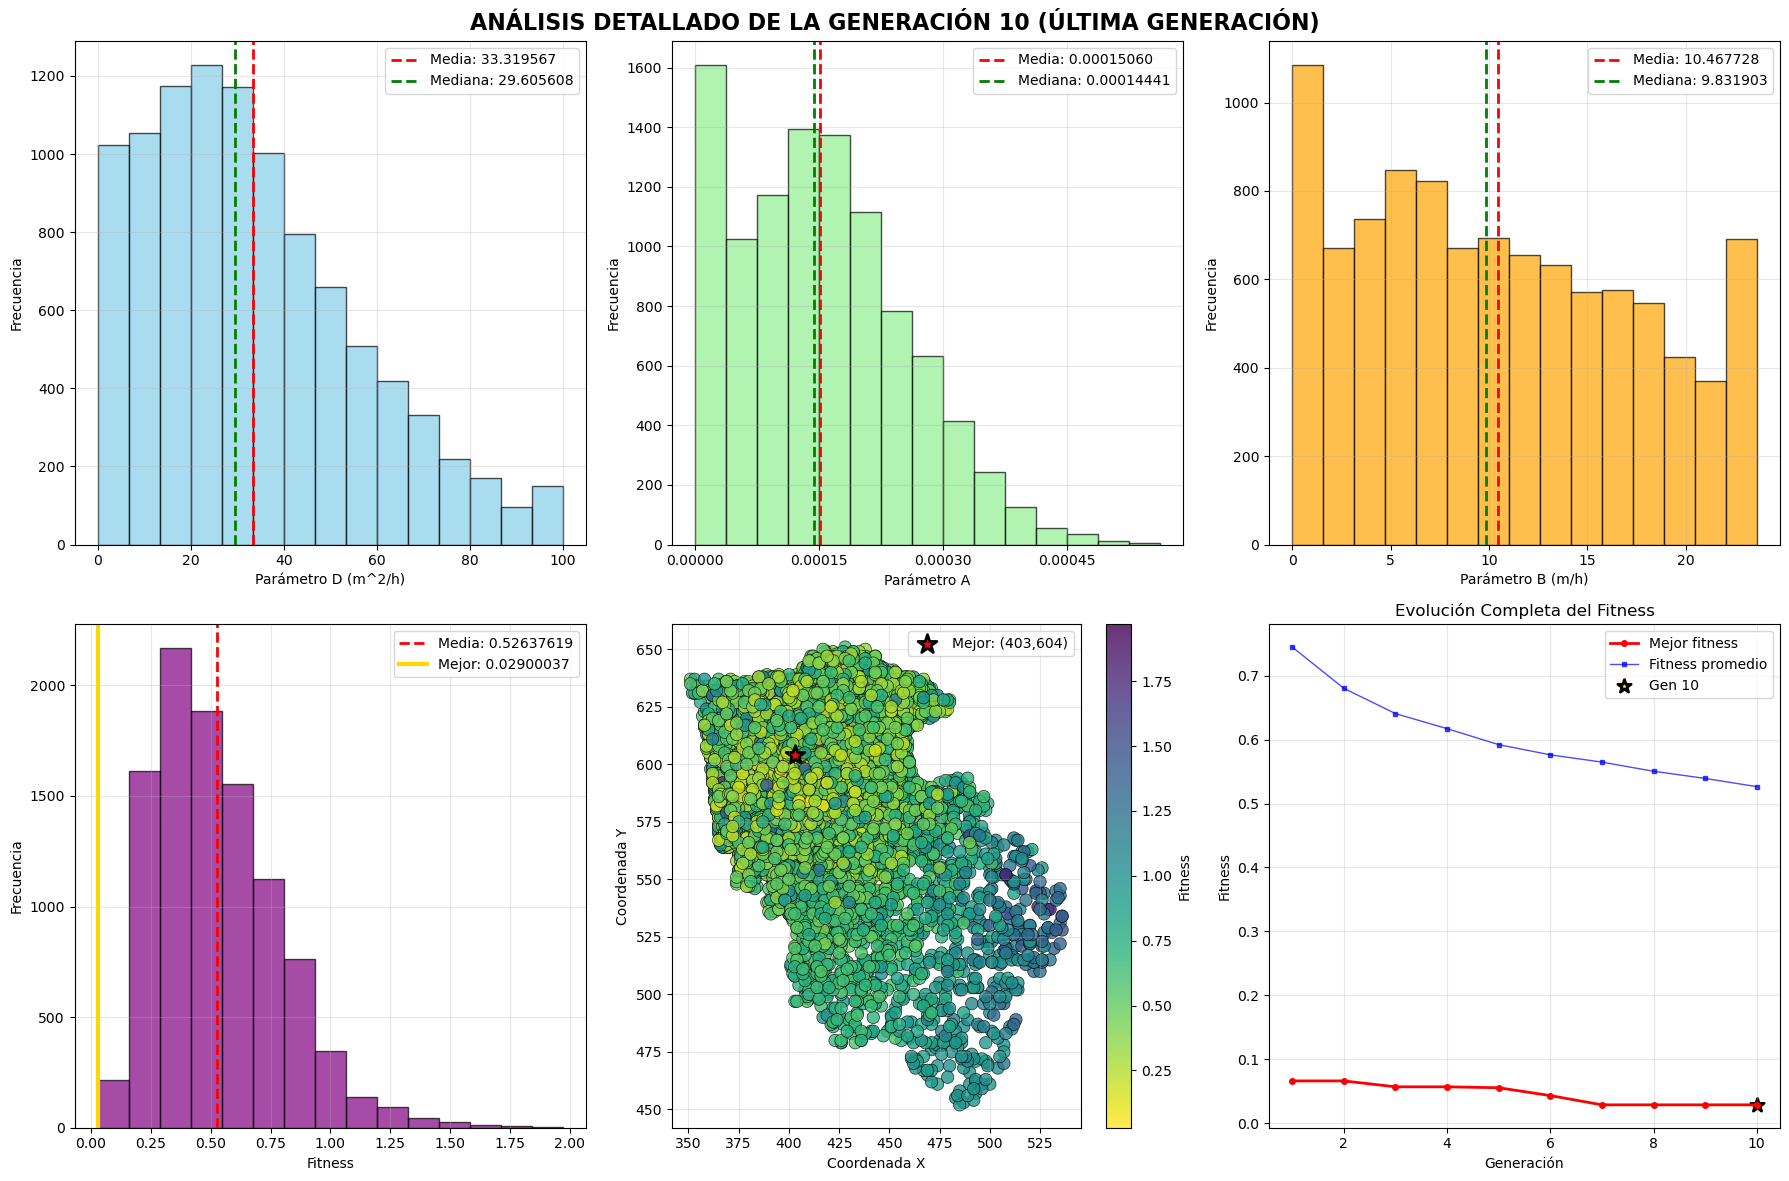


🔗 MATRIZ DE CORRELACIONES (GENERACIÓN 10):
------------------------------------------------------------
              D       A       B  fitness
D        1.0000  0.0509 -0.0638   0.1212
A        0.0509  1.0000 -0.2520   0.0722
B       -0.0638 -0.2520  1.0000   0.0168
fitness  0.1212  0.0722  0.0168   1.0000

🔍 CORRELACIONES SIGNIFICATIVAS (|r| > 0.3):
------------------------------------------------------------
  No se encontraron correlaciones significativas (|r| > 0.3)

📊 COMPARACIÓN CON GENERACIONES CLAVE:
------------------------------------------------------------
Gen  1: Mejor fitness = 0.06639314, Diversidad D = 28.826421
Gen  5: Mejor fitness = 0.05571615, Diversidad D = 27.358553
Gen 10: Mejor fitness = 0.02900037, Diversidad D = 22.685707


In [38]:
# Visualizaciones específicas para la ÚLTIMA GENERACIÓN
    
# Detectar automáticamente la última generación
ultima_generacion = df_total['generacion'].max()
gen_ultima = df_total[df_total['generacion'] == ultima_generacion].copy()
    
# Configurar las visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'ANÁLISIS DETALLADO DE LA GENERACIÓN {ultima_generacion} (ÚLTIMA GENERACIÓN)', 
             fontsize=16, fontweight='bold')
        
# 1. Distribución del parámetro D en la última generación
axes[0,0].hist(gen_ultima['D'], bins=15, color='skyblue', alpha=0.7, edgecolor='black')
axes[0,0].axvline(gen_ultima['D'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Media: {gen_ultima["D"].mean():.6f}')
axes[0,0].axvline(gen_ultima['D'].median(), color='green', linestyle='--', linewidth=2,
                  label=f'Mediana: {gen_ultima["D"].median():.6f}')
axes[0,0].set_xlabel('Parámetro D (m^2/h)')
axes[0,0].set_ylabel('Frecuencia')
# axes[0,0].set_title(f'Distribución de D (Gen {ultima_generacion})')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Distribución del parámetro A en la última generación
axes[0,1].hist(gen_ultima['A'], bins=15, color='lightgreen', alpha=0.7, edgecolor='black')
ticks = np.linspace(gen_ultima['A'].min(), gen_ultima['A'].max(), 6)
axes[0,1].xaxis.set_major_locator(MaxNLocator(nbins=6))
axes[0,1].axvline(gen_ultima['A'].mean(), color='red', linestyle='--', linewidth=2,
                         label=f'Media: {gen_ultima["A"].mean():.8f}')
axes[0,1].axvline(gen_ultima['A'].median(), color='green', linestyle='--', linewidth=2,
                         label=f'Mediana: {gen_ultima["A"].median():.8f}')
axes[0,1].set_xlabel('Parámetro A')
axes[0,1].set_ylabel('Frecuencia')
# axes[0,1].set_title(f'Distribución de A (Gen {ultima_generacion})')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Distribución del parámetro B en la última generación
axes[0,2].hist(gen_ultima['B'], bins=15, color='orange', alpha=0.7, edgecolor='black')
axes[0,2].axvline(gen_ultima['B'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["B"].mean():.6f}')
axes[0,2].axvline(gen_ultima['B'].median(), color='green', linestyle='--', linewidth=2,
                 label=f'Mediana: {gen_ultima["B"].median():.6f}')
axes[0,2].set_xlabel('Parámetro B (m/h)')
axes[0,2].set_ylabel('Frecuencia')
# axes[0,2].set_title(f'Distribución de B (Gen {ultima_generacion})')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Distribución del fitness en la última generación
axes[1,0].hist(gen_ultima['fitness'], bins=15, color='purple', alpha=0.7, edgecolor='black')
axes[1,0].axvline(gen_ultima['fitness'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Media: {gen_ultima["fitness"].mean():.8f}')
axes[1,0].axvline(gen_ultima['fitness'].min(), color='gold', linestyle='-', linewidth=3,
                 label=f'Mejor: {gen_ultima["fitness"].min():.8f}')
axes[1,0].set_xlabel('Fitness')
axes[1,0].set_ylabel('Frecuencia')
# axes[1,0].set_title(f'Distribución de Fitness (Gen {ultima_generacion})')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Puntos de ignición coloreados por fitness (última generación)
scatter = axes[1,1].scatter(gen_ultima['x'], gen_ultima['y'], 
                          c=gen_ultima['fitness'], cmap='viridis_r', 
                          alpha=0.8, s=80, edgecolors='black', linewidth=0.5)
        
# Destacar el mejor individuo
mejor_gen_ultima = gen_ultima.loc[gen_ultima['fitness'].idxmin()]
axes[1,1].scatter(mejor_gen_ultima['x'], mejor_gen_ultima['y'], 
                 c='red', s=200, marker='*', edgecolors='black', linewidth=2,
                 label=f'Mejor: ({mejor_gen_ultima["x"]:.0f},{mejor_gen_ultima["y"]:.0f})')
        
axes[1,1].set_xlabel('Coordenada X')
axes[1,1].set_ylabel('Coordenada Y')
# axes[1,1].set_title(f'Puntos de Ignición (Gen {ultima_generacion})')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1,1], label='Fitness')

# 6. Evolución del fitness a lo largo de TODAS las generaciones
mejores_por_gen = df_total.groupby('generacion')['fitness'].min().sort_index()
fitness_promedio = df_total.groupby('generacion')['fitness'].mean().sort_index()

axes[1,2].plot(mejores_por_gen.index, mejores_por_gen.values, 'o-', 
              color='red', linewidth=2, markersize=4, label='Mejor fitness')
axes[1,2].plot(fitness_promedio.index, fitness_promedio.values, 's-', 
              color='blue', alpha=0.7, linewidth=1, markersize=3, label='Fitness promedio')
        
# Destacar la transición entre fases si existe
if ultima_generacion > 19:
    axes[1,2].axvline(x=19.5, color='gray', linestyle='--', alpha=0.7, 
                      label='Transición Fase 1→2')
        
# Destacar la última generación
axes[1,2].scatter(ultima_generacion, mejores_por_gen[ultima_generacion], 
                 color='gold', s=100, marker='*', edgecolors='black', linewidth=2,
                 label=f'Gen {ultima_generacion}')
        
axes[1,2].set_xlabel('Generación')
axes[1,2].set_ylabel('Fitness')
axes[1,2].set_title('Evolución Completa del Fitness')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de correlaciones específico para la última generación
print(f"\n🔗 MATRIZ DE CORRELACIONES (GENERACIÓN {ultima_generacion}):")
print("-" * 60)

correlaciones_gen_ultima = gen_ultima[['D', 'A', 'B', 'fitness']].corr()
print(correlaciones_gen_ultima.round(4))

# Identificar correlaciones fuertes
print(f"\n🔍 CORRELACIONES SIGNIFICATIVAS (|r| > 0.3):")
print("-" * 60)

correlaciones_encontradas = False
for i, param1 in enumerate(['D', 'A', 'B']):
    for j, param2 in enumerate(['D', 'A', 'B', 'fitness']):
        if i != j or param2 == 'fitness':
            corr_val = correlaciones_gen_ultima.loc[param1, param2]
            if abs(corr_val) > 0.3:
                direccion = "positiva" if corr_val > 0 else "negativa"
                print(f"  {param1} ↔ {param2}: {corr_val:.4f} ({direccion})")
                correlaciones_encontradas = True
        
if not correlaciones_encontradas:
    print("  No se encontraron correlaciones significativas (|r| > 0.3)")
        
# Comparación con generaciones anteriores clave
if ultima_generacion > 1:
    print(f"\n📊 COMPARACIÓN CON GENERACIONES CLAVE:")
    print("-" * 60)
    
    generaciones_clave = [1, 10, 19] if ultima_generacion > 19 else [1, ultima_generacion//2]
    generaciones_clave = [g for g in generaciones_clave if g in df_total['generacion'].unique()]
    generaciones_clave.append(ultima_generacion)
    
    for gen in generaciones_clave:
        gen_data = df_total[df_total['generacion'] == gen]
        mejor_fitness = gen_data['fitness'].min()
        diversidad_D = gen_data['D'].std()
        print(f"Gen {gen:2d}: Mejor fitness = {mejor_fitness:.8f}, Diversidad D = {diversidad_D:.6f}")
        

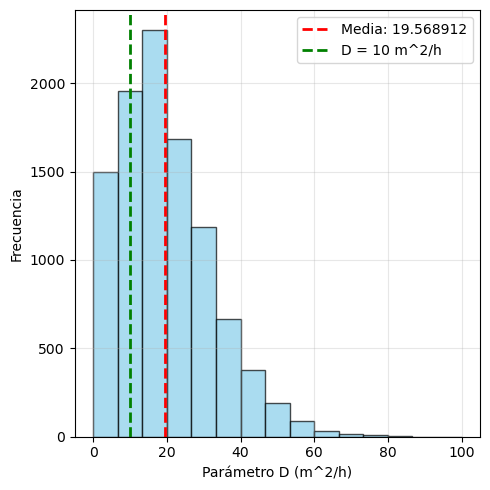

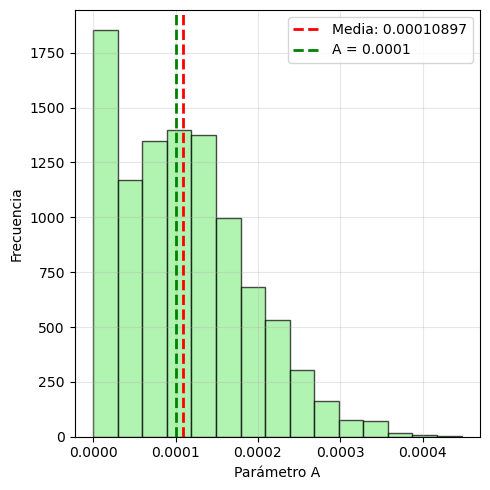

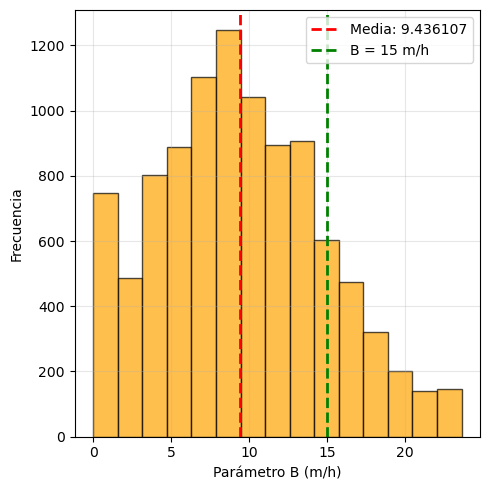

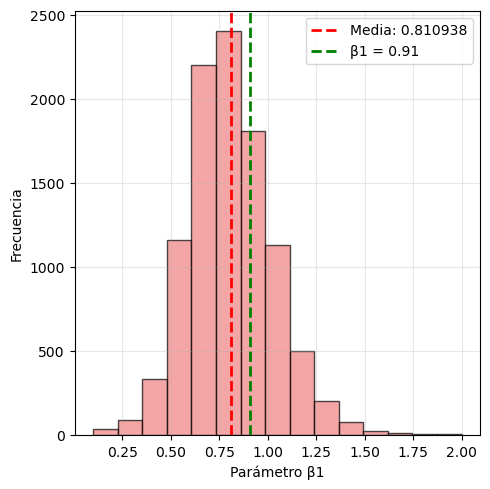

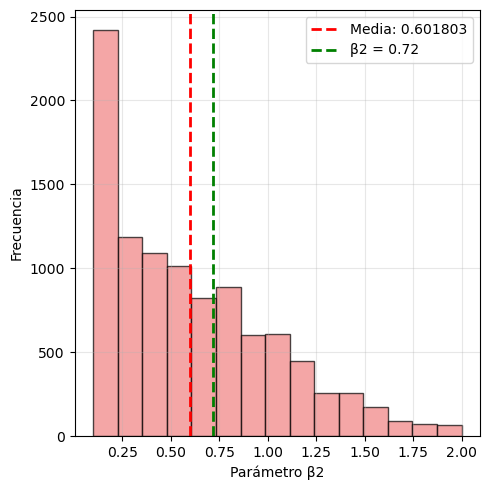

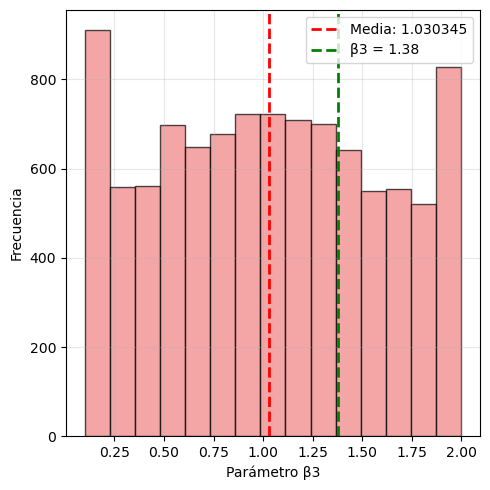

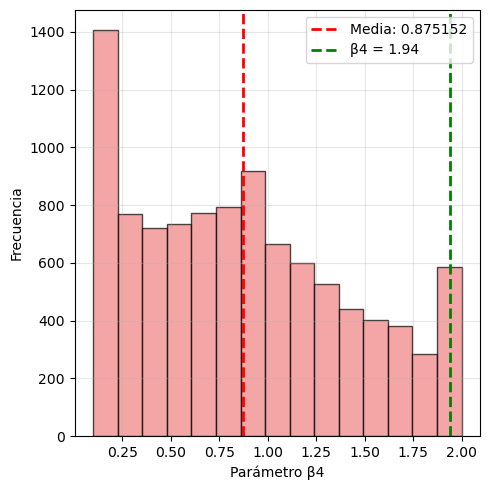

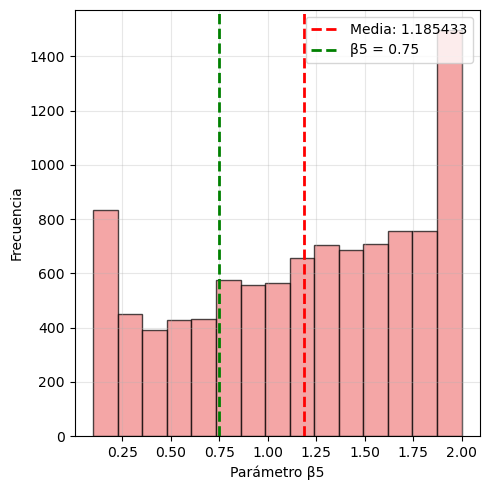

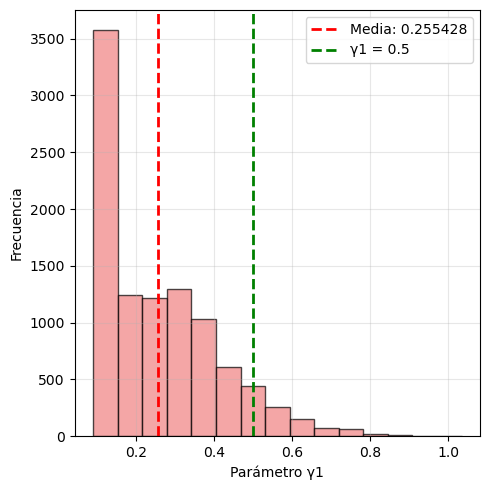

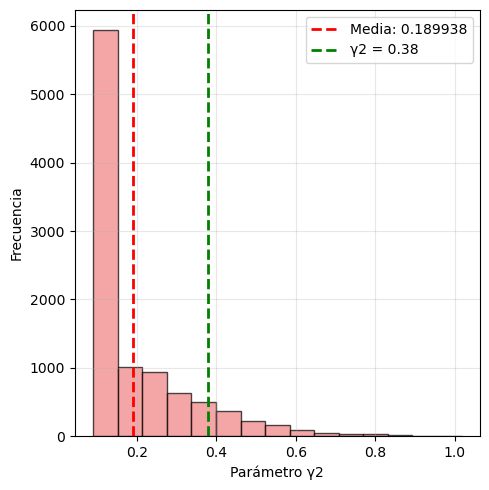

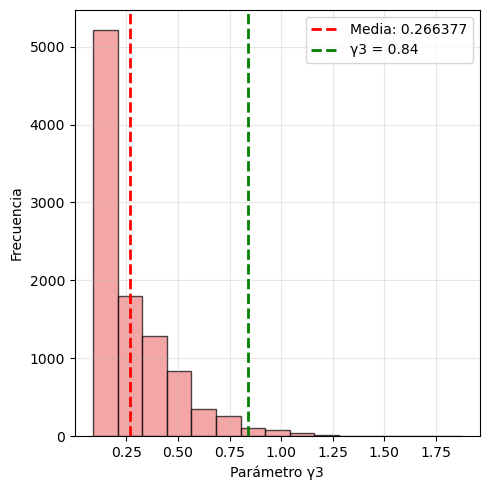

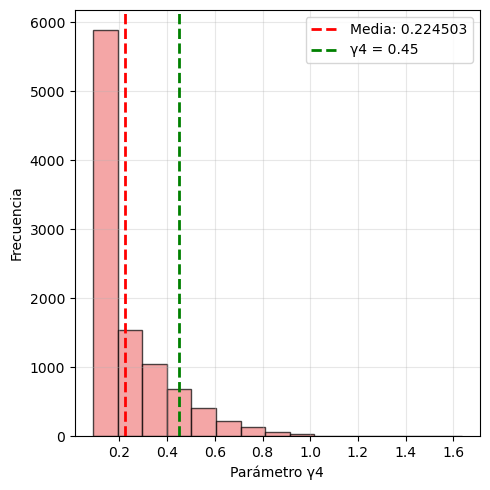

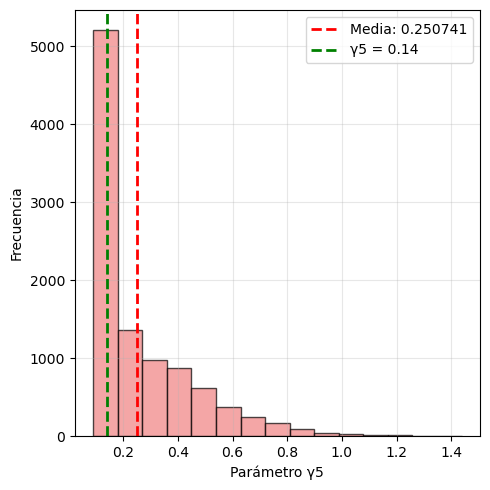

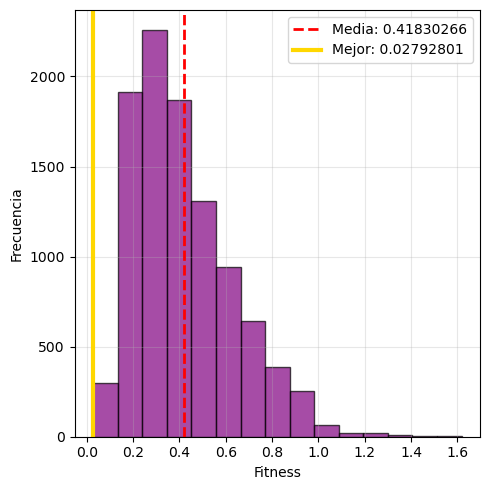

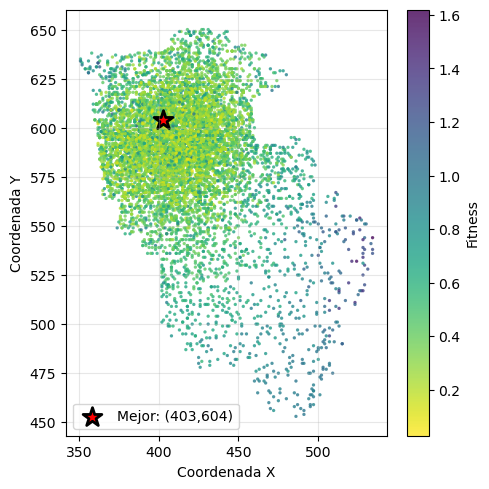

In [16]:
# Visualizaciones específicas para la ÚLTIMA GENERACIÓN
    
# Detectar automáticamente la última generación
ultima_generacion = df_total['generacion'].max()
gen_ultima = df_total[df_total['generacion'] == ultima_generacion].copy()

# 1. Distribución del parámetro D en la última generación
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['D'], bins=15, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(gen_ultima['D'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Media: {gen_ultima["D"].mean():.6f}')
plt.axvline(10, color='green', linestyle='--', linewidth=2,
                  label=f'D = {10} m^2/h')
ax.set_xlabel('Parámetro D (m^2/h)')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_D_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# 2. Distribución del parámetro A en la última generación
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['A'], bins=15, color='lightgreen', alpha=0.7, edgecolor='black')
ticks = np.linspace(gen_ultima['A'].min(), gen_ultima['A'].max(), 6)
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
plt.axvline(gen_ultima['A'].mean(), color='red', linestyle='--', linewidth=2,
                         label=f'Media: {gen_ultima["A"].mean():.8f}')
plt.axvline(1e-4, color='green', linestyle='--', linewidth=2,
                         label=f'A = {1e-4}')
ax.set_xlabel('Parámetro A')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_A_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# 3. Distribución del parámetro B en la última generación
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['B'], bins=15, color='orange', alpha=0.7, edgecolor='black')
plt.axvline(gen_ultima['B'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["B"].mean():.6f}')
plt.axvline(15, color='green', linestyle='--', linewidth=2,
                 label=f'B = {15} m/h')
ax.set_xlabel('Parámetro B (m/h)')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_B_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['beta_1'], bins=15, color='lightcoral', alpha=0.7, edgecolor='black')
plt.axvline(gen_ultima['beta_1'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["beta_1"].mean():.6f}')
plt.axvline(0.91, color='green', linestyle='--', linewidth=2,
                 label=f'β1 = {0.91}')
ax.set_xlabel('Parámetro β1')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_beta_1_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['beta_2'], bins=15, color='lightcoral', alpha=0.7, edgecolor='black')
plt.axvline(gen_ultima['beta_2'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["beta_2"].mean():.6f}')
plt.axvline(0.72, color='green', linestyle='--', linewidth=2,
                 label=f'β2 = {0.72}')
ax.set_xlabel('Parámetro β2')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_beta_2_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['beta_3'], bins=15, color='lightcoral', alpha=0.7, edgecolor='black')
plt.axvline(gen_ultima['beta_3'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["beta_3"].mean():.6f}')
plt.axvline(1.38, color='green', linestyle='--', linewidth=2,
                 label=f'β3 = {1.38}')
ax.set_xlabel('Parámetro β3')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_beta_3_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['beta_4'], bins=15, color='lightcoral', alpha=0.7, edgecolor='black')
plt.axvline(gen_ultima['beta_4'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["beta_4"].mean():.6f}')
plt.axvline(1.94, color='green', linestyle='--', linewidth=2,
                 label=f'β4 = {1.94}')
ax.set_xlabel('Parámetro β4')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_beta_4_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['beta_5'], bins=15, color='lightcoral', alpha=0.7, edgecolor='black')
plt.axvline(gen_ultima['beta_5'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["beta_5"].mean():.6f}')
plt.axvline(0.75, color='green', linestyle='--', linewidth=2,
                 label=f'β5 = {0.75}')
ax.set_xlabel('Parámetro β5')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_beta_5_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['gamma_1'], bins=15, color='lightcoral', alpha=0.7, edgecolor='black')
plt.axvline(gen_ultima['gamma_1'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["gamma_1"].mean():.6f}')
plt.axvline(0.5, color='green', linestyle='--', linewidth=2,
                 label=f'γ1 = {0.5}')
ax.set_xlabel('Parámetro γ1')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_gamma_1_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['gamma_2'], bins=15, color='lightcoral', alpha=0.7, edgecolor='black')
plt.axvline(gen_ultima['gamma_2'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["gamma_2"].mean():.6f}')
plt.axvline(0.38, color='green', linestyle='--', linewidth=2,
                 label=f'γ2 = {0.38}')
ax.set_xlabel('Parámetro γ2')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_gamma_2_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['gamma_3'], bins=15, color='lightcoral', alpha=0.7, edgecolor='black')
plt.axvline(gen_ultima['gamma_3'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["gamma_3"].mean():.6f}')
plt.axvline(0.84, color='green', linestyle='--', linewidth=2,
                 label=f'γ3 = {0.84}')
ax.set_xlabel('Parámetro γ3')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_gamma_3_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['gamma_4'], bins=15, color='lightcoral', alpha=0.7, edgecolor='black')
plt.axvline(gen_ultima['gamma_4'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["gamma_4"].mean():.6f}')
plt.axvline(0.45, color='green', linestyle='--', linewidth=2,
                 label=f'γ4 = {0.45}')
ax.set_xlabel('Parámetro γ4')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_gamma_4_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['gamma_5'], bins=15, color='lightcoral', alpha=0.7, edgecolor='black')
plt.axvline(gen_ultima['gamma_5'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Media: {gen_ultima["gamma_5"].mean():.6f}')
plt.axvline(0.14, color='green', linestyle='--', linewidth=2,
                 label=f'γ5 = {0.14}')
ax.set_xlabel('Parámetro γ5')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_gamma_5_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# 4. Distribución del fitness en la última generación
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(gen_ultima['fitness'], bins=15, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(gen_ultima['fitness'].mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Media: {gen_ultima["fitness"].mean():.8f}')
plt.axvline(gen_ultima['fitness'].min(), color='gold', linestyle='-', linewidth=3,
                 label=f'Mejor: {gen_ultima["fitness"].min():.8f}')
ax.set_xlabel('Fitness')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'distribucion_fitness_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# 5. Puntos de ignición coloreados por fitness (última generación)
fig, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(gen_ultima['x'], gen_ultima['y'], 
                          c=gen_ultima['fitness'], s=5, cmap='viridis_r', 
                          alpha=0.8, linewidths=0.1)
plt.savefig(f'distribucion_puntos_ignicion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

# Destacar el mejor individuo
mejor_gen_ultima = gen_ultima.loc[gen_ultima['fitness'].idxmin()]
plt.scatter(mejor_gen_ultima['x'], mejor_gen_ultima['y'], 
                 c='red', s=200, marker='*', edgecolors='black', linewidth=2,
                 label=f'Mejor: ({mejor_gen_ultima["x"]:.0f},{mejor_gen_ultima["y"]:.0f})')
ax.set_xlabel('Coordenada X')
ax.set_ylabel('Coordenada Y')
plt.legend()
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Fitness')
plt.tight_layout()
plt.savefig(f'distribucion_fitness_generacion_{ultima_generacion}.png', dpi=300, bbox_inches='tight')

In [28]:
import numpy as np

# Detectar automáticamente la última generación
ultima_generacion = df_total['generacion'].max()
gen_ultima = df_total[df_total['generacion'] == ultima_generacion].copy()

print("🎯 ANÁLISIS DE CONVERGENCIA Y RECOMENDACIONES FINALES")
print("=" * 80)
print(f"Analizando evolución completa: Gen 1 → Gen {ultima_generacion}")

# 1. Evaluación de la convergencia del algoritmo
mejores_por_gen = df_total.groupby('generacion')['fitness'].min().sort_index()
primera_gen = mejores_por_gen.index[0]

print(f"\n📈 CONVERGENCIA DEL ALGORITMO:")
print("-" * 50)
print(f"Mejor fitness generación {primera_gen}:  {mejores_por_gen.iloc[0]:.8f}")
print(f"Mejor fitness generación {ultima_generacion}: {mejores_por_gen.iloc[-1]:.8f}")

mejora_total = mejores_por_gen.iloc[0] - mejores_por_gen.iloc[-1]
mejora_porcentual = (mejora_total / mejores_por_gen.iloc[0]) * 100

print(f"Mejora absoluta: {mejora_total:.8f}")
print(f"Mejora relativa: {mejora_porcentual:.2f}%")
print(f"Total de generaciones: {len(mejores_por_gen)}")

# Evaluar convergencia en las últimas generaciones
ultimas_5 = mejores_por_gen.tail(5)
mejora_reciente = ultimas_5.iloc[0] - ultimas_5.iloc[-1] if len(ultimas_5) >= 2 else 0
    
if abs(mejora_reciente) < 1e-8:
    print("⚠️  ALGORITMO CONVERGIDO: Muy poca mejora en las últimas 5 generaciones")
    print(f"   Mejora en últimas 5 gen: {mejora_reciente:.10f}")
else:
    print(f"✓  Aún hay progreso: mejora en últimas 5 gen = {mejora_reciente:.8f}")
        
# Análisis de fases (si hay transición)
if ultima_generacion > 19:
    print(f"\n🔄 ANÁLISIS DE FASES:")
    print("-" * 50)
            
    # Fase 1: task_1808222 (Gen 1-19)
    datos_fase1 = df_total[df_total['generacion'] <= 19]
    mejor_fase1 = datos_fase1.groupby('generacion')['fitness'].min()
    mejora_fase1 = mejor_fase1.iloc[0] - mejor_fase1.iloc[-1]
            
    # Fase 2: task_1808329 (Gen 20+)
    datos_fase2 = df_total[df_total['generacion'] > 19]
    mejor_fase2 = datos_fase2.groupby('generacion')['fitness'].min()
    mejora_fase2 = mejor_fase2.iloc[0] - mejor_fase2.iloc[-1] if len(mejor_fase2) > 1 else 0
            
    print(f"FASE 1 (Gen 1-19, task_1808222):")
    print(f"  - Mejor inicial: {mejor_fase1.iloc[0]:.8f}")
    print(f"  - Mejor final: {mejor_fase1.iloc[-1]:.8f}")
    print(f"  - Mejora: {mejora_fase1:.8f}")
            
    print(f"FASE 2 (Gen 20-{ultima_generacion}, task_1808329):")
    print(f"  - Mejor inicial: {mejor_fase2.iloc[0]:.8f}")
    print(f"  - Mejor final: {mejor_fase2.iloc[-1]:.8f}")
    print(f"  - Mejora: {mejora_fase2:.8f}")
            
    # Analizar continuidad entre fases
    transicion = mejor_fase1.iloc[-1] - mejor_fase2.iloc[0]
    if abs(transicion) < 1e-8:
        print("  ✅ Transición suave entre fases")
    elif transicion > 0:
        print(f"  ⚠️  Empeoramiento en transición: {transicion:.8f}")
    else:
        print(f"  🚀 Mejora inmediata en fase 2: {-transicion:.8f}")
        
# 2. Análisis de diversidad en la generación final
print(f"\n🧬 DIVERSIDAD EN LA GENERACIÓN FINAL:")
print("-" * 50)
        
# Calcular coeficientes de variación
cv_D = (gen_ultima['D'].std() / gen_ultima['D'].mean()) * 100
cv_A = (gen_ultima['A'].std() / gen_ultima['A'].mean()) * 100  
cv_B = (gen_ultima['B'].std() / gen_ultima['B'].mean()) * 100
        
print(f"Coeficiente de variación D: {cv_D:.2f}%")
print(f"Coeficiente de variación A: {cv_A:.2f}%")
print(f"Coeficiente de variación B: {cv_B:.2f}%")

# Interpretación de la diversidad
diversidad_promedio = (cv_D + cv_A + cv_B) / 3
        
if diversidad_promedio < 5:
    estado_diversidad = "🎯 ALTA CONVERGENCIA: La población está muy concentrada"
elif diversidad_promedio < 15:
    estado_diversidad = "⚖️  CONVERGENCIA MODERADA: Buena concentración con algo de diversidad"
else:
    estado_diversidad = "🌐 ALTA DIVERSIDAD: La población aún está explorando ampliamente"
        
print(f"Diversidad promedio: {diversidad_promedio:.2f}% - {estado_diversidad}")

# 3. Análisis de los mejores parámetros
print(f"\n🏆 ANÁLISIS DE LOS MEJORES PARÁMETROS (GEN {ultima_generacion}):")
print("-" * 50)
        
mejor_gen_ultima = gen_ultima.loc[gen_ultima['fitness'].idxmin()]
        
# Comparar con el mejor global
mejor_global = df_total.loc[df_total['fitness'].idxmin()]
        
print(f"Mejor individuo de la generación {ultima_generacion}:")
print(f"  D = {mejor_gen_ultima['D']:.8f}  (coeficiente de difusión)")
print(f"  A = {mejor_gen_ultima['A']:.10f}  (factor de viento)")
print(f"  B = {mejor_gen_ultima['B']:.8f}  (factor de pendiente)")
print(f"  Ignición: ({mejor_gen_ultima['x']:.0f}, {mejor_gen_ultima['y']:.0f})")
print(f"  Fitness: {mejor_gen_ultima['fitness']:.10f}")
        
if mejor_global['generacion'] != ultima_generacion:
    print(f"\nNOTA: El mejor global está en la generación {mejor_global['generacion']}:")
    print(f"  Fitness global: {mejor_global['fitness']:.10f}")
    print(f"  Diferencia: {mejor_gen_ultima['fitness'] - mejor_global['fitness']:.10f}")
else:
    print(f"\n✅ El mejor individuo global está en la última generación")
        
# 4. Validación física de los parámetros
print(f"\n🔬 VALIDACIÓN FÍSICA DE LOS MEJORES PARÁMETROS:")
print("-" * 50)
        
# Usar el mejor global para la validación
mejor_para_validar = mejor_global
        
# Rangos típicos esperados para incendios forestales
D_tipico = [0.001, 0.1]  # m²/s
A_tipico = [0.0001, 0.01]  # adimensional
B_tipico = [0.1, 10.0]  # m/s
        
def validar_rango(valor, rango, nombre):
    if rango[0] <= valor <= rango[1]:
        return f"✓ {nombre}: {valor:.6f} (dentro del rango esperado {rango})"
    else:
        return f"⚠️ {nombre}: {valor:.6f} (fuera del rango típico {rango})"
        
print(validar_rango(mejor_para_validar['D'], D_tipico, "D"))
print(validar_rango(mejor_para_validar['A'], A_tipico, "A"))
print(validar_rango(mejor_para_validar['B'], B_tipico, "B"))
        
# 5. Estadísticas de robustez
print(f"\n💪 ROBUSTEZ DE LA SOLUCIÓN:")
print("-" * 50)

# Top 10% de la última generación
top_10_percent = max(1, int(len(gen_ultima) * 0.1))
mejores_gen_ultima = gen_ultima.nsmallest(top_10_percent, 'fitness')

print(f"Analizando los mejores {top_10_percent} individuos de la generación {ultima_generacion}:")
print(f"  D promedio: {mejores_gen_ultima['D'].mean():.8f} ± {mejores_gen_ultima['D'].std():.8f}")
print(f"  A promedio: {mejores_gen_ultima['A'].mean():.10f} ± {mejores_gen_ultima['A'].std():.10f}")
print(f"  B promedio: {mejores_gen_ultima['B'].mean():.8f} ± {mejores_gen_ultima['B'].std():.8f}")
print(f"  Fitness promedio: {mejores_gen_ultima['fitness'].mean():.8f}")
print(f"  Rango de fitness: [{mejores_gen_ultima['fitness'].min():.8f}, {mejores_gen_ultima['fitness'].max():.8f}]")

# 6. Análisis de rendimiento del algoritmo
print(f"\n⚡ RENDIMIENTO DEL ALGORITMO:")
print("-" * 50)

# Calcular mejora por generación promedio
mejora_por_gen = -np.diff(mejores_por_gen.values)  # Negativo porque fitness menor es mejor
mejora_promedio = np.mean(mejora_por_gen)

print(f"Mejora promedio por generación: {mejora_promedio:.8f}")
print(f"Generaciones con mejora: {np.sum(mejora_por_gen > 1e-10)}/{len(mejora_por_gen)}")
print(f"Eficiencia: {(np.sum(mejora_por_gen > 1e-10)/len(mejora_por_gen))*100:.1f}% de generaciones útiles")

# 7. Recomendaciones finales
print(f"\n💡 RECOMENDACIONES FINALES:")
print("-" * 50)
        
if abs(mejora_reciente) < 1e-8:
    print("1. ✅ El algoritmo ha convergido exitosamente")
    print("   → Los parámetros encontrados son estables")
    print("   → Recomendado: USAR los parámetros actuales")
else:
    print("1. 🔄 Considerar ejecutar más generaciones")
    print("   → Aún hay potencial de mejora")
    print("   → Recomendado: CONTINUAR optimización")
        
if diversidad_promedio < 10:
    print("2. 🎯 La población está bien convergida")
    print("   → Los parámetros encontrados son confiables")
else:
    print("2. 🌐 La población mantiene diversidad")
    print("   → Considerar criterios de parada más estrictos")
        
if ultima_generacion >= 30:
    print("3. 📏 Algoritmo ejecutado extensivamente")
    print("   → Suficientes generaciones para convergencia sólida")
else:
    print("3. 🕐 Algoritmo en desarrollo")
    print("   → Considerar más generaciones para mejor convergencia")
        
print("4. 🔬 Próximos pasos recomendados:")
print("   → Ejecutar simulaciones de validación con los mejores parámetros")
print("   → Realizar análisis de sensibilidad")
print("   → Comparar con datos experimentales disponibles")
        
if ultima_generacion > 19:
    print("5. 📊 Análisis de múltiples fases completado")
    print("   → Los resultados integran la exploración de ambas carpetas")
    print("   → Mayor confianza en los parámetros por exploración extendida")
        
# Crear un resumen final conciso
print(f"\n📋 RESUMEN EJECUTIVO:")
print("=" * 50)
print(f"✅ Generaciones analizadas: {primera_gen} - {ultima_generacion} ({len(mejores_por_gen)} total)")
print(f"✅ Mejor fitness alcanzado: {mejor_global['fitness']:.8f} (Gen {mejor_global['generacion']})")
print(f"✅ Parámetros óptimos: D={mejor_global['D']:.6f}, A={mejor_global['A']:.8f}, B={mejor_global['B']:.6f}")
print(f"✅ Convergencia: {'Lograda' if abs(mejora_reciente) < 1e-8 else 'En progreso'}")
print(f"✅ Diversidad final: {'Baja (convergida)' if diversidad_promedio < 10 else 'Moderada/Alta'}")
print(f"✅ Mejora total: {mejora_porcentual:.2f}%")
        
estado_final = "USAR PARÁMETROS" if abs(mejora_reciente) < 1e-8 else "CONTINUAR OPTIMIZACIÓN"
print(f"✅ Recomendación final: {estado_final}")

🎯 ANÁLISIS DE CONVERGENCIA Y RECOMENDACIONES FINALES
Analizando evolución completa: Gen 1 → Gen 57

📈 CONVERGENCIA DEL ALGORITMO:
--------------------------------------------------
Mejor fitness generación 1:  0.10112679
Mejor fitness generación 57: 0.02230822
Mejora absoluta: 0.07881858
Mejora relativa: 77.94%
Total de generaciones: 57
✓  Aún hay progreso: mejora en últimas 5 gen = 0.00295925

🔄 ANÁLISIS DE FASES:
--------------------------------------------------
FASE 1 (Gen 1-19, task_1808222):
  - Mejor inicial: 0.10112679
  - Mejor final: 0.02526747
  - Mejora: 0.07585932
FASE 2 (Gen 20-57, task_1808329):
  - Mejor inicial: 0.02526747
  - Mejor final: 0.02230822
  - Mejora: 0.00295925
  ✅ Transición suave entre fases

🧬 DIVERSIDAD EN LA GENERACIÓN FINAL:
--------------------------------------------------
Coeficiente de variación D: 23.27%
Coeficiente de variación A: 11.38%
Coeficiente de variación B: 16.46%
Diversidad promedio: 17.04% - 🌐 ALTA DIVERSIDAD: La población aún está exp